In [110]:
# imports
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [159]:
# Read our data
df = pd.read_csv("../data/soc-redditHyperlinks-body.tsv", sep="\t")

# Remove unnecessary columns
df = df[["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT", "LINK_SENTIMENT"]]

# Assign id to each subreddit
verticies = np.concat([df["SOURCE_SUBREDDIT"].to_numpy(), df["TARGET_SUBREDDIT"].to_numpy()])
verticies = np.unique(verticies)
id_to_subreddit = dict(enumerate(verticies))
subreddit_to_id = dict((v,k) for k,v in id_to_subreddit.items())

print(f"Number of verticies: {len(verticies)}")
print(f"Number of edges: {len(df)}")

# Replace subreddit name with id
# df = df.map(lambda s: subreddit_to_id.get(s) if s in subreddit_to_id else s)

# Create Multi Directed Graph from raw data
MDG = nx.MultiDiGraph()
MDG.add_nodes_from(verticies)
MDG.add_weighted_edges_from(list(df.itertuples(index=False, name=None)))

# Create Directed Graph by summing weights on edges
DG = nx.DiGraph(MDG)
nx.set_edge_attributes(DG, 0, "weight")
nx.set_edge_attributes(DG, 0, "pos")
nx.set_edge_attributes(DG, 0, "neg")
nx.set_edge_attributes(DG, 0.0, "ratio")

for u, v, d in MDG.edges(data=True):
    if d['weight'] > 0:
        DG[u][v]['pos'] += 1
    elif d['weight'] < 0:
        DG[u][v]['neg'] += 1
    DG[u][v]['weight'] += d['weight']
    DG[u][v]['ratio'] = DG[u][v]['pos'] / (DG[u][v]['pos'] + DG[u][v]['neg']) 


Number of verticies: 35776
Number of edges: 286561


After summing the edge weights we can find subreddits that interact most positively and most negatively with each other.

In [160]:
sorted = list(DG.edges.data())
sorted.sort(key=lambda x: x[2]['weight'], reverse=True)

print(f"Subreddits with the most positive relations:")
for (u, v, d) in sorted[:20]:
    print(f"{u} said {d['weight']} more positive than negative things about {v}.")


print(f"\nSubreddits with the most negative relations:")
for (u, v, d) in sorted[-20:]:
    print(f"{u} said {-d['weight']} more negative than positive things about {v}.")


Subreddits with the most positive relations:
trendingsubreddits said 548 more positive than negative things about changelog.
mushroomkingdom said 243 more positive than negative things about gamesale.
buildapc said 242 more positive than negative things about buildapcforme.
bluejackets said 223 more positive than negative things about bluejacketsgwg.
summonerschool said 212 more positive than negative things about leagueoflegends.
atletico said 209 more positive than negative things about soccer.
fireemblemcasual said 206 more positive than negative things about fireemblem.
streetfighter said 201 more positive than negative things about sf4.
acturnips said 187 more positive than negative things about ratemymayor.
babymetal said 186 more positive than negative things about sakuragakuin.
longhornnation said 180 more positive than negative things about cfb.
cig_rca said 175 more positive than negative things about starcitizen.
iama said 166 more positive than negative things about books.


By looking at the degree we can see who is having the most positive and negative interactions overall:

In [162]:
deg_sorted = list(DG.degree(weight='pos'))
deg_sorted.sort(key=lambda d: d[1], reverse=True)

print("Most positive interactions:")
for x in deg_sorted[:10]:
    print(x)

print("\nLeast positive interactions:")
for x in deg_sorted[-10:]:
    print(x)

Most positive interactions:
('askreddit', 7576)
('iama', 4664)
('subredditdrama', 4095)
('writingprompts', 3807)
('leagueoflegends', 3101)
('outoftheloop', 2585)
('pics', 2419)
('nfl', 2121)
('buildapc', 2095)
('videos', 2077)

Least positive interactions:
('xtianity', 0)
('xxs', 0)
('yamadaandsevenwitches', 0)
('yolomadden', 0)
('yourmom', 0)
('youtubefactsbot', 0)
('zionismwatch', 0)
('zodiackiller', 0)
('zog', 0)
('zugorphans', 0)


By looking at the out-degree we can see who is spreading the most positivity and who is spreading the most hate:

In [164]:
deg_sorted = list(DG.out_degree(weight='pos'))
deg_sorted.sort(key=lambda d: d[1], reverse=True)

print("Talking most positively about others:")
for x in deg_sorted[:10]:
    print(x)

deg_sorted = list(DG.out_degree(weight='neg'))
deg_sorted.sort(key=lambda d: d[1], reverse=True)

print("\nTalking most negatively about others:")
for x in deg_sorted[:10]:
    print(x)

Talking most positively about others:
('subredditdrama', 3228)
('outoftheloop', 1820)
('circlebroke', 1656)
('shitliberalssay', 1561)
('copypasta', 1452)
('hailcorporate', 1432)
('writingprompts', 1420)
('buildapc', 1304)
('tipofmypenis', 1201)
('conspiracy', 1181)

Talking most negatively about others:
('subredditdrama', 1437)
('circlebroke', 702)
('drama', 518)
('shitliberalssay', 407)
('circlejerkcopypasta', 380)
('copypasta', 372)
('writingprompts', 287)
('conspiracy', 281)
('bestofoutrageculture', 229)
('karmacourt', 210)


## Graphing the Data

We can take the most positively interacted with subreddits and visualise the relations of this smaller dataset.

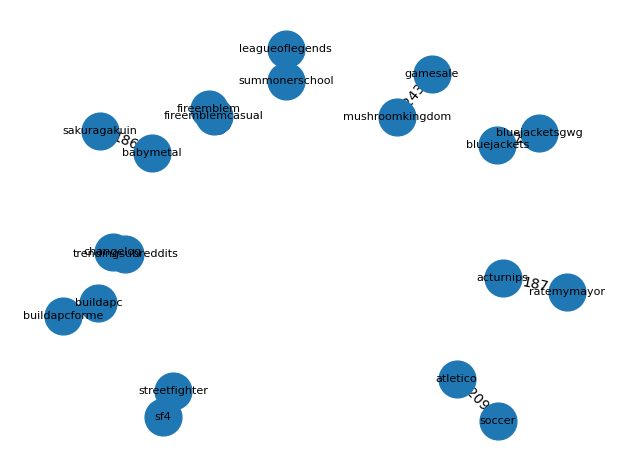

In [263]:
ex = list(DG.edges.data())
ex.sort(key=lambda x: x[2]['weight'], reverse=True)
ex = ex[:10]
ex = [(x[0], x[1]) for x in ex]

tDG = DG.edge_subgraph(ex)

pos = nx.spring_layout(tDG)

nx.draw_networkx_nodes(tDG, pos, node_size=700)

nx.draw_networkx_edges(tDG, pos, width=10)

nx.draw_networkx_labels(tDG, pos, font_size=8, font_family="sans-serif")

edge_labels = nx.get_edge_attributes(tDG, "weight")
nx.draw_networkx_edge_labels(tDG, pos, edge_labels)

ax = plt.gca()
# ax.margins(0.08)
plt.axis("off")

plt.tight_layout()
plt.show()

Interestingly, subreddits that have the most positive interactions got them in a large part by farming them with another, closely related subreddit, e.g. athletic - soccer, buildapc - buildapcforme, fireemblem - fireemblemcasual, etc.

We have uncovered a major flaw within the dataset.

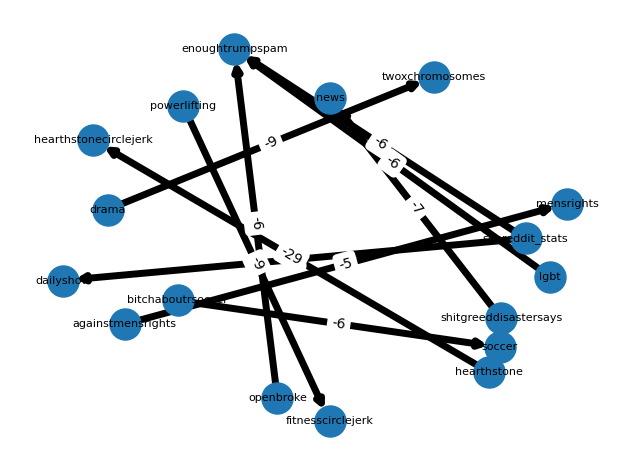

In [282]:
ex = list(DG.edges.data())
ex.sort(key=lambda x: x[2]['weight'])
ex = ex[:10]
ex = [(x[0], x[1]) for x in ex]

tDG = DG.edge_subgraph(ex)

pos = nx.spring_layout(tDG)

nx.draw_networkx_nodes(tDG, pos, node_size=500)

nx.draw_networkx_edges(tDG, pos, width=5)

nx.draw_networkx_labels(tDG, pos, font_size=8, font_family="sans-serif")

edge_labels = nx.get_edge_attributes(tDG, "weight")
nx.draw_networkx_edge_labels(tDG, pos, edge_labels)

ax = plt.gca()
# ax.margins(0.08)
plt.axis("off")

plt.tight_layout()
plt.show()

Interestingly, with negative interactions we see a completely opposite pattern - the relation is usually unreciprocated. We can see some quite predictable matchings with e.g. againstmensrights - mensrights and bitchaboutsoccer - soccer.